<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Regressão-Logística-com-Regularização" data-toc-modified-id="Regressão-Logística-com-Regularização-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Regressão Logística com Regularização</a></span><ul class="toc-item"><li><span><a href="#Lendo-e-Explorando-Dados" data-toc-modified-id="Lendo-e-Explorando-Dados-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Lendo e Explorando Dados</a></span></li><li><span><a href="#Feature-Mapping" data-toc-modified-id="Feature-Mapping-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Feature Mapping</a></span></li><li><span><a href="#Função-Custo-Regularizada" data-toc-modified-id="Função-Custo-Regularizada-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Função Custo Regularizada</a></span></li><li><span><a href="#Gradiente-Regularizado" data-toc-modified-id="Gradiente-Regularizado-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Gradiente Regularizado</a></span></li></ul></li></ul></div>

Este notebook tem por objetivo a implementação, em Python, da segunda parte do exercício 2 do curso de Aprendizagem Automática da Universidade de Stanford. Concluída a primeira parte referente a um problema de Regressão Logística, neste ponto do aprendizado é proposto um problema de Regressão Logística com ```Regularização```.

Em outras palavras, é esperado um problema onde seja necessário definir uma função de um grau maior superior e, por consequência, curvilínia. A regularização atua de modo a dosar os pesos dos parâmetros relacionados aos graus elevados de ```x```, garantindo que o modelo não sofra de ```overfitting```. Para isto, novas equações de Custo e Gradiente deverão ser definidas levando em consideração uma penalização para tais termos. Vejamos.

## Regressão Logística com Regularização

No problema proposto, iremos implementar um algoritmo de Regressão Logística para Controle de Qualidade em uma fábrica de microchips com o intuito de verificar se peças são aprovadas ou não.

O dataset contém resultados de dois testes de cada um dos 118 microchips da cadeia de produção e, em sua última coluna, o resultado da aprovação ou não no Teste de Qualidade.

### Lendo e Explorando Dados

In [1]:
# Importando biblioteca
import numpy as np

dataset = np.loadtxt('ex2data2.txt', delimiter=',')
dataset[:5]

array([[ 0.051267,  0.69956 ,  1.      ],
       [-0.092742,  0.68494 ,  1.      ],
       [-0.21371 ,  0.69225 ,  1.      ],
       [-0.375   ,  0.50219 ,  1.      ],
       [-0.51325 ,  0.46564 ,  1.      ]])

In [2]:
# Dimensões do dataset
dataset.shape

(118, 3)

Até o momento, o problema está muito semelhante ao anterior, inclusive na quantidade de dados.

In [3]:
# Visualizando dados
import matplotlib.pyplot as plt
%matplotlib inline

positive_class = dataset[dataset[:, 2] == 1]
negative_class = dataset[dataset[:, 2] == 0]

In [4]:
# Verificando
positive_class[:10]

array([[ 0.051267,  0.69956 ,  1.      ],
       [-0.092742,  0.68494 ,  1.      ],
       [-0.21371 ,  0.69225 ,  1.      ],
       [-0.375   ,  0.50219 ,  1.      ],
       [-0.51325 ,  0.46564 ,  1.      ],
       [-0.52477 ,  0.2098  ,  1.      ],
       [-0.39804 ,  0.034357,  1.      ],
       [-0.30588 , -0.19225 ,  1.      ],
       [ 0.016705, -0.40424 ,  1.      ],
       [ 0.13191 , -0.51389 ,  1.      ]])

In [5]:
# Verificando
negative_class[:10]

array([[0.18376 , 0.93348 , 0.      ],
       [0.22408 , 0.77997 , 0.      ],
       [0.29896 , 0.61915 , 0.      ],
       [0.50634 , 0.75804 , 0.      ],
       [0.61578 , 0.7288  , 0.      ],
       [0.60426 , 0.59722 , 0.      ],
       [0.76555 , 0.50219 , 0.      ],
       [0.92684 , 0.3633  , 0.      ],
       [0.82316 , 0.27558 , 0.      ],
       [0.96141 , 0.085526, 0.      ]])

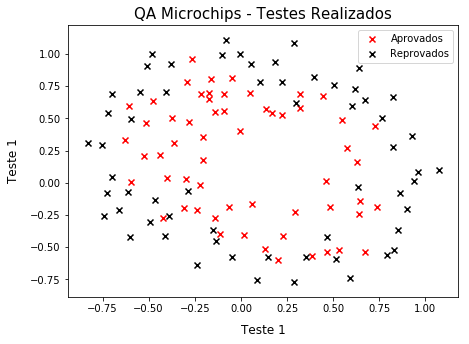

In [6]:
# Plotando dados
fig = plt.figure(figsize=(7, 5))
plt.scatter(positive_class[:, 0], positive_class[:, 1], marker='x', c='r')
plt.scatter(negative_class[:, 0], negative_class[:, 1], marker='x', c='k')
plt.title('QA Microchips - Testes Realizados', size=15)
plt.xlabel('Teste 1', size=12, labelpad=10)
plt.ylabel('Teste 1', size=12, labelpad=10)
plt.legend(['Aprovados', 'Reprovados'])
plt.show()

Aqui percebemos a diferença: para implementarmos uma regressão logística neste modelo, nossa função não poderá ser simplesmente linear. Os dados não são linearmente separavéis e, por conta disso, nossa função terá de ter um comportamento polinomial para alcançar os resultados pretendidos.

Para isto, vamos aplicar um procedimento chamado ```Map Feature``` com o objetivo de elevar o grau polinomial das nossas features (até a sexta potência). O cuidado que se tem de ter, como informado no bloco de introdução, é que modelos com alto grau polinomial tendem ao ```overfitting```, fator este combatido pela ```regularização```, a qual será implementada no decorrer deste exercício.

### Feature Mapping

Após algumas pesquisas, será necessário importar um módulo do scikit-learn para realizar este procedimento.

Fonte: [sklearn.preprocessing.PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)

In [7]:
# Importando biblioteca e aplicando feature mapping
from sklearn.preprocessing import PolynomialFeatures

X = dataset[:, :2]
y = dataset[:, -1].reshape(X.shape[0], 1)

# Testando com um grau=2
poly = PolynomialFeatures(2)
X2 = poly.fit_transform(X)
X2[:5]

array([[ 1.        ,  0.051267  ,  0.69956   ,  0.00262831,  0.03586434,
         0.48938419],
       [ 1.        , -0.092742  ,  0.68494   ,  0.00860108, -0.06352271,
         0.4691428 ],
       [ 1.        , -0.21371   ,  0.69225   ,  0.04567196, -0.14794075,
         0.47921006],
       [ 1.        , -0.375     ,  0.50219   ,  0.140625  , -0.18832125,
         0.2521948 ],
       [ 1.        , -0.51325   ,  0.46564   ,  0.26342556, -0.23898973,
         0.21682061]])

O que se esperava aconteceu: com o argumento = 2 dentro da inicialização da classe ```PolynomialFeatures()```, os dados foram transformados da seguinte forma:

    - coluna 0 = adicionado termo bias automaticamente (=1)
    - coluna 1 = antiga coluna 1, sem alterações
    - coluna 2 = antiga coluna 2, sem alterações
    - coluna 3 = x1^2 (coluna 1 ao quadrado)
    - coluna 4 = x1*x2 (coluna 1 * coluna 2)
    - coluna 5 = x2^2 (coluna 2 ao quadrado)

In [8]:
# Testando o exposto acima
amostra = X[0, :]
amostra

array([0.051267, 0.69956 ])

In [9]:
# Verificando
print(f'x1: {amostra[0]:>11}')
print(f'x2: {amostra[1]:>10}')
print(f'x1^2: {(amostra[0] ** 2):>15}')
print(f'x1*x2: {amostra[0] * amostra[1]:>11}')
print(f'x2^2: {(amostra[1] ** 2):>20}')

x1:    0.051267
x2:    0.69956
x1^2:  0.002628305289
x1*x2: 0.035864342519999995
x2^2:  0.48938419359999996


In [10]:
# Comparando com os dados obtidos no procedimento
print(f'Poly x1: {X2[0][1]:>11}')
print(f'Poly x2: {X2[0][2]:>10}')
print(f'Poly x1^2: {X2[0][3]:>15}')
print(f'Poly x1*x2: {X2[0][4]:>11}')
print(f'Poly x2^2: {X2[0][5]:>20}')

Poly x1:    0.051267
Poly x2:    0.69956
Poly x1^2:  0.002628305289
Poly x1*x2: 0.035864342519999995
Poly x2^2:  0.48938419359999996


É exatamente o que queremos, com a diferença no grau expadindo para a sexta potência!

In [11]:
# Expandindo para a sexta potência
poly = PolynomialFeatures(6)
X = poly.fit_transform(X)

# Verificando
X[:5]

array([[ 1.00000000e+00,  5.12670000e-02,  6.99560000e-01,
         2.62830529e-03,  3.58643425e-02,  4.89384194e-01,
         1.34745327e-04,  1.83865725e-03,  2.50892595e-02,
         3.42353606e-01,  6.90798869e-06,  9.42624411e-05,
         1.28625106e-03,  1.75514423e-02,  2.39496889e-01,
         3.54151856e-07,  4.83255257e-06,  6.59422333e-05,
         8.99809795e-04,  1.22782870e-02,  1.67542444e-01,
         1.81563032e-08,  2.47750473e-07,  3.38066048e-06,
         4.61305487e-05,  6.29470940e-04,  8.58939846e-03,
         1.17205992e-01],
       [ 1.00000000e+00, -9.27420000e-02,  6.84940000e-01,
         8.60107856e-03, -6.35227055e-02,  4.69142804e-01,
        -7.97681228e-04,  5.89122275e-03, -4.35092419e-02,
         3.21334672e-01,  7.39785525e-05, -5.46363780e-04,
         4.03513411e-03, -2.98012201e-02,  2.20094970e-01,
        -6.86091891e-06,  5.06708697e-05, -3.74226408e-04,
         2.76382476e-03, -2.04120477e-02,  1.50751849e-01,
         6.36295342e-07, -4.69

In [12]:
# Novas dimensões
X.shape

(118, 28)

Sim, agora temos 28 features mapeadas.

### Função Custo Regularizada

\begin{equation*}
             J(\theta)=\frac{1}{m}\sum_{i=1}^{m}[-y^{(i)}\log(h_\theta(x^{(i)})-
                      (1 - y^{(i)})\log(1 - h_\theta(x^{(i)})] + 
                      \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_j^2 
\end{equation*}

O último termo diminui a magnitude dos parâmetros (repare que o termo bias theta0 não é afetado, visto que o somatório vai de j=1 até n)

Já tínhamos a função custo vetorizada implementada no exercício anterior. Antes de resgatá-la, precisamos também da função sigmoidal.

In [13]:
# Calculando função sigmoidal
def sigmoid(z):
    """Função responsável por calcular o resultado sigmoidal, dado o parâmetro z
    Input:
        z: parâmetro z definido por theta.T * x
    Output:
        g(z): função sigmoidal aplicada ao parâmetro z"""
    return 1 / (1 + np.exp(-z))

In [14]:
# Testando função custo
[m, n] = X.shape
theta_inicial = np.zeros((n, 1)) + 2
theta_inicial[:5]

array([[2.],
       [2.],
       [2.],
       [2.],
       [2.]])

In [15]:
# Testando termo de regularização
(theta_inicial ** 2)[:5]

array([[4.],
       [4.],
       [4.],
       [4.],
       [4.]])

In [16]:
# Inicializando termos
theta_inicial = np.zeros((n, 1))
lamb = 1

# Calculando função hypothesis
z = X.dot(theta_inicial)
h = sigmoid(z)

# Definindo termos da função custo
termo1 = np.log(h).T.dot(-y)
termo2 = np.log(1 - h).T.dot(1 - y)
termo3 = theta_inicial.T.dot(theta_inicial)

# Função custo
J = ((termo1 - termo2) / m) + ((lamb/(2*m)) * termo3)

In [17]:
# Qual seria o custo para parâmetros zerados?
J

array([[0.69314718]])

Conforme o esperado, segundo o pdf do exerício. Vamos encapsular esse cálculo em uma função.

In [18]:
# Definindo função
def costFunction(X, theta, lamb):
    """
        Função responsável por computar o Custo com regularização para um problema
    de Regressão Logística.
    Input:
        - X: features
        - theta: parâmetros
        - lamb: termo de regularização
    Output:
        - J: função custo com regularização
    """
    # Inicializando termos
    [m, n] = X.shape

    # Calculando função hypothesis
    z = X.dot(theta_inicial)
    h = sigmoid(z)

    # Definindo termos da função custo
    termo1 = np.log(h).T.dot(-y)
    termo2 = np.log(1 - h).T.dot(1 - y)
    termo3 = theta_inicial.T.dot(theta_inicial)

    # Função custo
    J = ((termo1 - termo2) / m) + ((lamb/(2*m)) * termo3)
    return J

In [19]:
# Testando
costFunction(X, theta_inicial, 1)

array([[0.69314718]])

### Gradiente Regularizado

O gradiente também muda:

A derivada parcial da função custo em relação a theta faz com que o termo elevado ao quadrado caia sobre a fração de lambda e elimine o multiplicador de m, restando apenas (lambda/m)*theta.

__Ponto Importante:__ a regularização ```não``` é aplicada ao termo bias (```theta0```)!

\begin{equation*}
    \frac{\partial J(\theta)}{\partial\theta_j} = 
        \begin{cases} 
            \left(\frac{1}{m}\sum_{i=1}^m(h_\theta(x^{(i)})-y^{(i)})x_j^{(i)}\right)
                & \mbox{para } j\mbox{ = 0} \\
            \left(\frac{1}{m}\sum_{i=1}^m(h_\theta(x^{(i)})-y^{(i)})x_j^{(i)}\right) +
            \frac{\lambda}{m}\theta_j &\mbox{para } j\mbox{ >= 1}
        \end{cases}
\end{equation*}                                       

Equações:

https://tex.stackexchange.com/questions/38868/big-parenthesis-in-an-equation
https://tex.stackexchange.com/questions/225523/how-to-write-partial-differential-equation-ex-dq-dt-ds-dt-with-real-partial-d

In [20]:
# Testando
grad0 = (X.T.dot(h - y)) / m
grad1 = (X.T.dot(h - y) / m) + theta_inicial*(lamb/m)

In [24]:
grad0

array([[8.47457627e-03],
       [1.87880932e-02],
       [7.77711864e-05],
       [5.03446395e-02],
       [1.15013308e-02],
       [3.76648474e-02],
       [1.83559872e-02],
       [7.32393391e-03],
       [8.19244468e-03],
       [2.34764889e-02],
       [3.93486234e-02],
       [2.23923907e-03],
       [1.28600503e-02],
       [3.09593720e-03],
       [3.93028171e-02],
       [1.99707467e-02],
       [4.32983232e-03],
       [3.38643902e-03],
       [5.83822078e-03],
       [4.47629067e-03],
       [3.10079849e-02],
       [3.10312442e-02],
       [1.09740238e-03],
       [6.31570797e-03],
       [4.08503006e-04],
       [7.26504316e-03],
       [1.37646175e-03],
       [3.87936363e-02]])

In [25]:
grad1

array([[8.47457627e-03],
       [1.87880932e-02],
       [7.77711864e-05],
       [5.03446395e-02],
       [1.15013308e-02],
       [3.76648474e-02],
       [1.83559872e-02],
       [7.32393391e-03],
       [8.19244468e-03],
       [2.34764889e-02],
       [3.93486234e-02],
       [2.23923907e-03],
       [1.28600503e-02],
       [3.09593720e-03],
       [3.93028171e-02],
       [1.99707467e-02],
       [4.32983232e-03],
       [3.38643902e-03],
       [5.83822078e-03],
       [4.47629067e-03],
       [3.10079849e-02],
       [3.10312442e-02],
       [1.09740238e-03],
       [6.31570797e-03],
       [4.08503006e-04],
       [7.26504316e-03],
       [1.37646175e-03],
       [3.87936363e-02]])